In [11]:
!pip install timm
!pip install transformers
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from numpy import random

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import AutoModel, AutoTokenizer, AutoConfig

TSCOLS = 256

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Config

In [13]:
class CFG:
    debug = False
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    timeseries_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 20
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    text_encoder_model = "zhayunduo/roberta-base-stocktwits-finetuned"
    text_embedding = 768
    text_tokenizer = "zhayunduo/roberta-base-stocktwits-finetuned"
    timeseries_embedding = 256
    max_length = 200

    pretrained = True # for  text encoder
    trainable = True # for text encoder
    temperature = 1.0

    # image size
    # size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

## Utils

In [14]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


In [15]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, timeseries, captions, tokenizer):
        self.timeseries = list(timeseries)
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.normalizer = 'none'

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        if self.normalizer =='none':
            item['timeseries'] = torch.tensor(self.timeseries[idx]).float()
        if self.normalizer =='minmax':
            item['timeseries'] = (torch.tensor(self.timeseries[idx]).float() - torch.tensor(self.timeseries[idx]).float().min()) / (torch.tensor(self.timeseries[idx]).float().max() - torch.tensor(self.timeseries[idx]).float().min())
        if self.normalizer =='meansd':
            item['timeseries'] = (torch.tensor(self.timeseries[idx]).float() - torch.tensor(self.timeseries[idx]).float().mean()) / torch.tensor(self.timeseries[idx]).float().std()
            
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)


In [16]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = AutoModel.from_pretrained(model_name)
        else:
            self.model = AutoModel(config=AutoConfig())
            
        for p in self.model.parameters():
            p.requires_grad = False

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [17]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [18]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        text_embedding=CFG.text_embedding,
        timeseries_embedding=CFG.timeseries_embedding,
        use_timeseries_projection_head=True,
    ):
        super().__init__()
        self.text_encoder = TextEncoder()
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.ts_projection = ProjectionHead(embedding_dim=timeseries_embedding)
        self.temperature = temperature
        self.use_timeseries_projection_head = use_timeseries_projection_head

    def forward(self, batch):
        timeseries_features = batch["timeseries"]
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        if self.use_timeseries_projection_head:
            timeseries_embeddings = self.ts_projection(timeseries_features)
        else:
            timeseries_embeddings = timeseries_features
            
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ timeseries_embeddings.T) / self.temperature
        timeseries_similarity = timeseries_embeddings @ timeseries_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (timeseries_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

## Train

In [25]:
make_train_valid_dfs()[0]

,tweet,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,"$BTC Guys, Don't miss the next move in a few h...",29801.995,29794.070,29798.185,29803.050,29785.425,29747.500,29736.390,29746.020,29756.620,...,29745.645,29755.920,29767.145,29769.555,29762.285,29750.440,29729.875,29699.750,29686.305,29689.025
1,"Tick tock, tick tock to the $BTC cult 📉",20671.845,20673.970,20680.655,20664.340,20646.750,20646.860,20653.495,20659.665,20647.565,...,20621.000,20643.985,20625.005,20601.175,20603.335,20609.120,20613.965,20612.325,20605.655,20600.345
2,$ACH #AlchemyPay To Mars!!!🚀🚀🚀🚀🚀🚀🚀🚀 #cryptocur...,48815.125,48831.515,48865.430,48906.060,48861.335,48755.485,48663.220,48689.845,48786.455,...,49582.120,49589.005,49581.905,49558.950,49525.635,49472.760,49413.885,49424.415,49457.515,49462.600
3,$BTC trying to takeover here...👀,38221.060,38261.955,38295.115,38317.230,38295.780,38288.330,38390.540,38467.880,38486.255,...,39197.015,39171.640,39163.780,39175.240,39195.525,39193.840,39147.645,39117.985,39108.585,39104.475
4,@jared_tyndall @Darkunn @MikeFos88218598 @S_Pa...,33888.040,33888.400,33925.830,33992.365,34041.395,34030.205,33983.335,33891.985,33819.580,...,34156.470,34168.980,34179.625,34167.620,34151.410,34203.590,34309.200,34405.250,34450.605,34478.670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4692,@WisdomMatic @Dehkunle I bought $btc at 1k dol...,46575.685,46558.460,46569.335,46583.740,46606.265,46621.715,46615.230,46631.905,46634.555,...,46661.475,46655.200,46655.920,46655.915,46658.225,46686.230,46700.350,46711.670,46731.955,46729.350
4693,Be safe out there Fam! $BTC $ETH #Altcoins ...,43165.005,43173.785,43190.485,43214.290,43254.125,43290.035,43276.325,43252.225,43210.880,...,43339.630,43348.150,43341.050,43332.985,43332.060,43337.630,43334.230,43342.650,43345.280,43290.415
4694,$BTC - Condition 🤖 Pair: $BTCUSD Condition...,40375.170,40374.355,40369.280,40383.040,40393.750,40389.235,40389.235,40380.500,40367.350,...,40260.760,40266.795,40268.545,40273.880,40280.200,40275.585,40275.005,40279.200,40278.410,40280.140
4695,@LynAldenContact Replies are indeed laughable!...,16617.850,16616.155,16609.180,16600.040,16604.265,16621.175,16634.030,16635.560,16612.155,...,16797.590,16809.620,16819.785,16812.490,16814.895,16820.675,16832.590,16840.010,16827.495,16821.420


In [23]:
def make_train_valid_dfs():
    dataframe = pd.read_csv("/content/drive/MyDrive/BACHELOR'S DATA/train_val_data/BTC_train.csv")
    max_id = dataframe.shape[0]
    timeseries_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        timeseries_ids, size=int(0.2 * len(timeseries_ids)), replace=False
    )
    train_ids = [id_ for id_ in timeseries_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe.index.isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe.index.isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    dataset = CLIPDataset(
        # torch.from_numpy(dataframe.iloc[:, -TSCOLS:].values).long(),
        dataframe.iloc[:, -TSCOLS:].values,
        dataframe.iloc[:, 0].values,
        tokenizer=tokenizer,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [20]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["timeseries"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["timeseries"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": {}, "lr": CFG.timeseries_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain({}, model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

In [26]:
main()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 5


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 6


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 8


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 10


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 11


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 12


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 13


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 14


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 15


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 16


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 17


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 18


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 19


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch: 20


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Saved Best Model!


## Inference

Okay! We are done with training the model. Now, we need to do inference which in our case will be giving the model a piece of text and want it to retrieve the most relevant images from an unseen validation (or test) set.

### Getting Image Embeddings

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [29]:
def get_ts_embeddings(valid_df, model_path):
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    valid_timeseries_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            valid_timeseries_embeddings.append(batch["timeseries"])
    return model, torch.cat(valid_timeseries_embeddings)

In [30]:
valid_df = pd.read_csv("/content/drive/MyDrive/BACHELOR'S DATA/train_val_data/BTC_val.csv")
model, ts_embeddings = get_ts_embeddings(valid_df, "best.pt")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/62 [00:00<?, ?it/s]

### Finding Matches

This function does the final task that we wished our model would be capable of: it gets the model, image_embeddings, and a text query. It will display the most relevant images from the validation set! Isn't it amazing? Let's see how it performs after all!

In [31]:
def find_matches(model, timeseries_embeddings, query, n=9):
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    timeseries_embeddings_n = F.normalize(timeseries_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ timeseries_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches =  indices[::5]

    return matches

Find time series that correspond with the given text the most

In [32]:
matches = find_matches(model, 
             ts_embeddings,
             query="BTC is a rocket. UP UP UP!",
             n=9)
matches

tensor([1460,  638,  746, 1248,  224,  908,  897, 1718,  764])

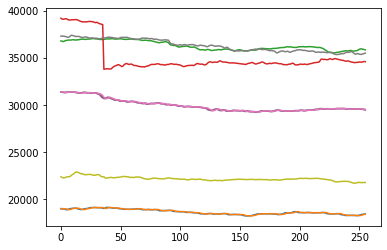

In [34]:
for i in ts_embeddings[matches]:
  plt.plot(i)